# Case Study: MyoPS - myocardial pathology segmentation

In [1]:
#hide
#skip
! [[ -e /content ]] && git clone https://github.com/chfc-cmi/misas && cd misas && pip install .
import os
if os.path.isdir('/content/misas'):
    os.chdir('/content/misas')

/bin/sh: 1: [[: not found


In [2]:
#hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Aim: Apply to MyoPS data

Text

In this case study we demonstrate how `misas` helps answer these questions with a concrete example:
 - **Model**: TODO
 - **Data**: TODO

## Prepare Model for `misas`

In [3]:
from fastai2.vision.all import *
from fastai2.vision.models import resnet34

In [4]:
class AddMaskCodeMapping(Transform):
    "Add mapping of pixel value to class for a `TensorMask`"
    def __init__(self, mapping, codes=None):
        #print("init")
        self.mapping = mapping
        self.codes = codes
        if codes is not None: self.vocab,self.c = codes,len(codes)

    def encodes(self, o:PILMask):
        #print("encodes")
        mo = ToTensor()(o)
        mo = mo.to(dtype=torch.long)
        mo = self.mapping.index_select(0,mo.flatten()).reshape(*mo.shape)
        mo = PILMask.create(mo.to(dtype=torch.uint8))
        return mo
    
    def decodes(self, o:TensorMask):
        # decoding of inputs works out of the box, but get_preds are not properly decoded
        if len(o.shape) > 2:
            o = o.argmax(dim=0)
        if self.codes is not None: o._meta = {'codes': self.codes}
        return o

In [5]:
def MappedMaskBlock(mapping,codes=None):
    "A `TransformBlock` for segmentation masks, with mapping of pixel values to classes, potentially with `codes`"
    return TransformBlock(type_tfms=PILMask.create, item_tfms=AddMaskCodeMapping(mapping=mapping,codes=codes), batch_tfms=IntToFloatTensor)

In [6]:
def getMappedMaskBlock(predefined_mapping_name):
    predefined_mappings = {
        'full': ([0,1,2,3,4,5],['bg','lv','my','rv','ed','sc']),
        'edOnly': ([0,0,0,0,1,0],['bg','ed']),
        'edScCombined': ([0,0,0,0,1,1],['bg','edSc']),
        'scOnly': ([0,0,0,0,0,1],['bg','sc']),
        'edScOnly': ([0,0,0,0,1,2],['bg','ed','sc']),
    }
    mapping,codes = predefined_mappings[predefined_mapping_name]
    return MappedMaskBlock(mapping = torch.LongTensor(mapping), codes=codes)

In [7]:
def get_train_files(path):
    items = get_image_files(path)
    items = L([x for x in items if x.name.startswith("1")])
    return items

In [8]:
def getMyopsDls(mapping_name="full", images="images", path='example/myops'):
    mmb = getMappedMaskBlock(mapping_name)
    myopsData = DataBlock(blocks=(ImageBlock, mmb),#['bg','lv','my','rv','ed','sc'])),
        get_items=get_train_files,
        splitter=FuncSplitter(lambda o: False),
        get_y=lambda o: str(o).replace(images,"masks"),
        item_tfms=CropPad(256),
        batch_tfms=aug_transforms(max_rotate=90,pad_mode="zeros"))
    dls = myopsData.dataloaders(f'{path}/{images}',num_workers=4,batch_size=12)
    dls[1].bs = 12
    return dls

In [9]:
def multi_dice(input:Tensor, targs:Tensor, class_id=0, inverse=False)->Tensor:
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    # replace all with class_id with 1 all else with 0 to have binary case
    output = (input == class_id).float()
    # same for targs
    targs = (targs.view(n,-1) == class_id).float()
    if inverse:
        output = 1 - output
        targs = 1 - targs
    intersect = (output * targs).sum(dim=1).float()
    union = (output+targs).sum(dim=1).float()
    res = 2. * intersect / union
    res[torch.isnan(res)] = 1
    return res.mean()

def diceFG(input, targs): return multi_dice(input,targs,class_id=1)
def diceLV(input, targs): return multi_dice(input,targs,class_id=1)
def diceMY(input, targs): return multi_dice(input,targs,class_id=2)
def diceRV(input, targs): return multi_dice(input,targs,class_id=3)
def diceEd(input, targs): return multi_dice(input,targs,class_id=4)
def diceSc(input, targs): return multi_dice(input,targs,class_id=5)
dices = [diceLV,diceMY,diceRV,diceEd,diceSc]

In [10]:
learn = unet_learner(
        getMyopsDls("full", "images"),
        resnet34
    )

In [11]:
from fastai.vision import Image as F1Image
from fastai.vision import ImageSegment as F1ImageSegment

## Prepare Dataset for `misas`

Data is available as png images and masks which is just fine for `misas`

In [12]:
from fastai.vision import open_image, open_mask

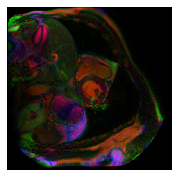

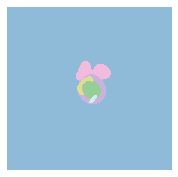

In [13]:
img = lambda: open_image("example/myops/images/101-orig-4.png")
trueMask = lambda: open_mask("example/myops/masks/101-orig-4.png")
img().show()
trueMask().show()

In [14]:
class Fastai2_model:
    def __init__(self, learner):
        self.trainedModel = learner
        
    def prepareSize(self, item, asPIL=False):
        if isinstance(item, F1ImageSegment):
            pilmask = PILMask(Image.fromarray((item.data.squeeze(0)).numpy().astype(np.uint8)))
            pilmask = CropPad(256)(pilmask)
            return F1ImageSegment(torch.ByteTensor(np.array(pilmask)).unsqueeze(0))
        pilimg = PILImage(Image.fromarray((item.data.permute(1,2,0) * 255).numpy().astype(np.uint8)))
        pilimg = CropPad(256)(pilimg)
        if asPIL:
            return pilimg
        return F1Image(torch.Tensor(np.array(pilimg)/255).permute(2,0,1))
        
    def predict(self, image):
        pilimg = self.prepareSize(image, asPIL=True)
        with self.trainedModel.no_bar():
            mask,probs,rest = self.trainedModel.predict(pilimg)
        return F1ImageSegment(torch.ByteTensor(np.array(mask)).unsqueeze(0)),probs

# model = Fastai1_model('example/b0','b0_transversal_5_5') # if it were local
model = Fastai2_model(learn.load("../example/myops/multi_ce_full"))

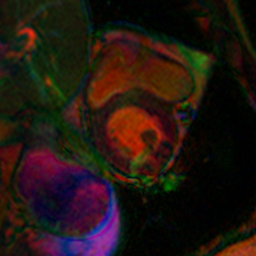

In [15]:
model.prepareSize(img())

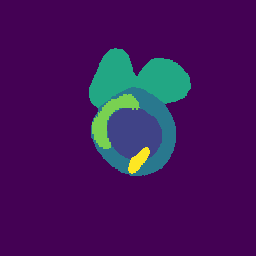

In [16]:
model.prepareSize(trueMask())

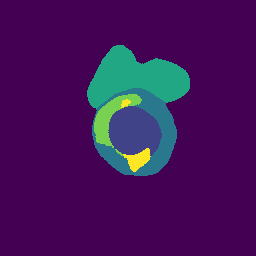

In [17]:
mask = model.predict(img())[0]
mask

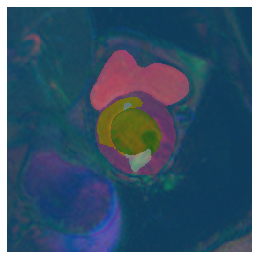

In [103]:
model.prepareSize(img()).show(y=mask,figsize=(4.5,4.5))

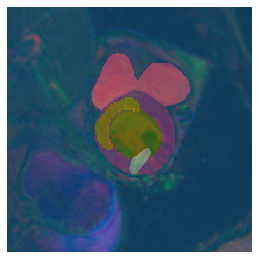

In [105]:
model.prepareSize(img()).show(y=model.prepareSize(trueMask()),figsize=(4.5,4.5))

## How does the trained model perform on this (training) example?

Time to apply the model to the example image and see how it works (we need to call `prepareSize` manually here):

So how does it perform on validation data?

This is not great. But given the limited training data it looks decent. So let's have a closer look on how robust this model is. In particular to differences we might encounter when applying this network to new data. 

## Robustness to basic transformations

In [19]:
#hide
import warnings
warnings.filterwarnings('ignore')

In [75]:
from misas.core import *

In [21]:
#img = lambda: open_image(files[0]).resize(256)
#trueMask = lambda: open_mask(files[0].replace("image","mask"))

### Sensitivity to orientation

Changes in orientation are very common. Not because it is common to acquire images in different orientation but because the way data is stored in different file formats like nifti and dicom differs. So it is interesting to see how the model works in all possible orientations (including flips).

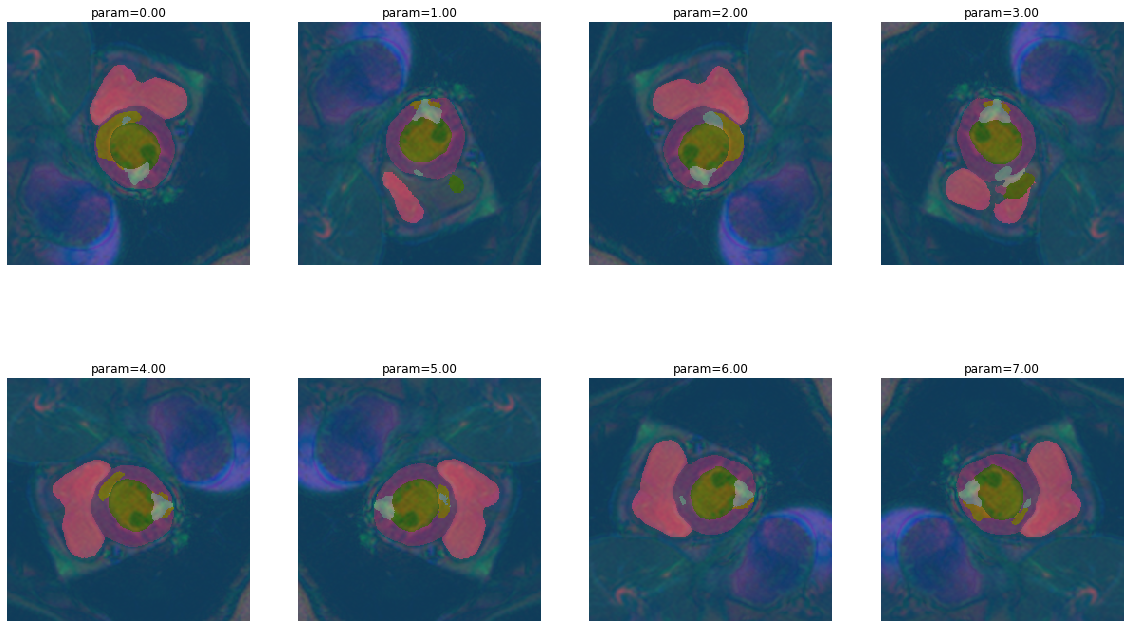

In [22]:
dihed = get_dihedral_series(img(),model)
plot_series(dihed, nrow=2, figsize=(20,12))

Not surprisingly, the model is very sensitive to changes in orientation. So when using this model it is very important to feed the images in the proper orientation.

Another really interesting thing is happening, for parameters 2 and 3 (top row, right) a heart shaped mask is drawn in the right side of the image. However, these images are flipped so the shape is actually in the wrong side of the torax. This gives a strong indication that the location within the image is one of the features the network has learned.
Depending on your use case this might indeed be a sensible feature to use for segmentation of the heart as in a huge majority of cases the left ventricle of the heart is on the left side of the chest (so showing up on the right side in transversal slices).

### Sensitivity to rotation

There should not be a huge variation in rotation (by small angles) when working with transversal slices. Still it is a good idea to get an impression of how quickly segmentation performance decreases with deviations in rotation.

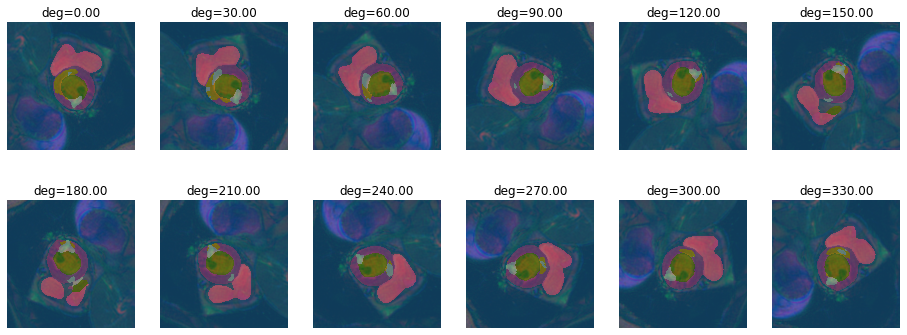

In [23]:
plot_series(get_rotation_series(img(),model, step=30), nrow=2, param_name="deg")

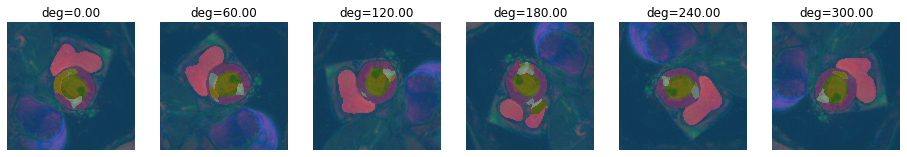

In [96]:
plot_series(get_rotation_series(img(),model, step=60), nrow=1, param_name="deg")

In [24]:
results = eval_rotation_series(img(),trueMask(),model,start=-180,end=180,components=["bg","LV","MY","RV","edema","scar"])

In [25]:
import altair as alt

In [26]:
(alt
 .Chart(results.melt(id_vars=['deg'],value_vars=['LV','MY','RV','edema','scar']))
 .mark_line()
 .encode(
     x="deg",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

So there is quite a range (from -40 to 80 degrees) where prediction performance remains stable. This is sufficient not to worry about minor deviations.

Let's have another look at the network moving to the wrong side of thorax when predicting on rotated images:

In [27]:
gif_series(
    get_rotation_series(img(),model, start=1, end=360,step=10),
    "example/myops/rotation.gif",
    param_name="deg",
    duration=400
)

![segmentation sensitivity to rotation](example/myops/rotation.gif)

### Sensitivity to cropping

Another variation that might occur in real life is a difference in field of view. This can happen due to different settings when acquiring the images or due to pre-processing steps in an analysis pipeline.

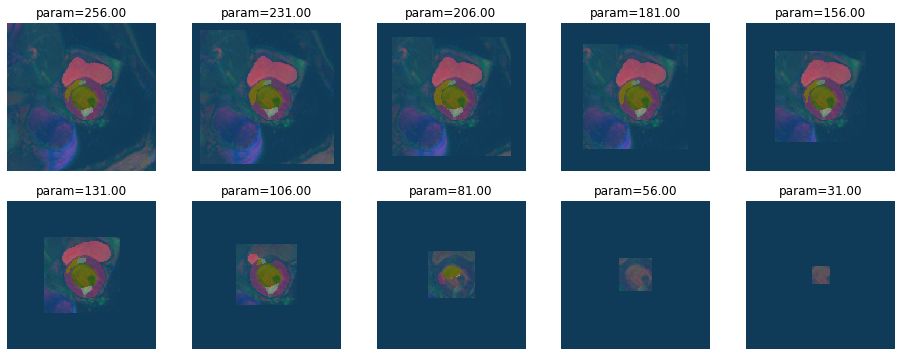

In [28]:
plot_series(get_crop_series(img(),model, start = 256, end = 30, step = -25, finalSize=400), nrow=2, vmax=5)

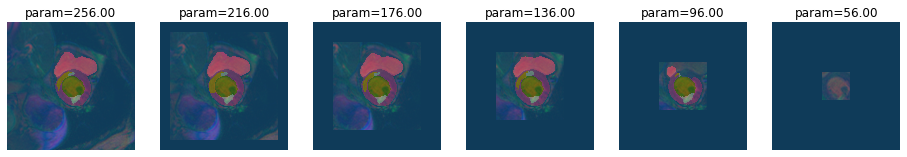

In [97]:
plot_series(get_crop_series(img(),model, start = 256, end = 30, step = -40, finalSize=400), nrow=1, vmax=5)

In [29]:
gif_series(
    get_crop_series(img(),model, start=250, end=50,step=-10),
    "example/myops/crop.gif",
    param_name="pixels",
    duration=400,
    vmax=5
)

![segmentation sensitivity to rotation - myops](example/myops/crop.gif)

This looks quite good. It seems to be okay to crop the image as long as the whole heart remains intact. As soon as we start to crop part of the heart the model is no longer able to find it (this is expected). It also does not start to predict heart somewhere, where it should not when cropping even further.

In [66]:
results = eval_crop_series(img(),trueMask(),model,start = 50, end=256, finalSize=400, components=["bg","LV","MY","RV","edema","scar"])

In [67]:
(alt
 .Chart(results.melt(id_vars=['pixels'],value_vars=['LV','MY','RV','edema','scar']))
 .mark_line()
 .encode(
     x="pixels",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

The dice scores of 1 for very small sizes is because the model is not supposed to predict anything and it is not predicting anything. It drops to 0 when the heart starts to appear on the image but the model is still unable to locate it and then raises to the final performance it has on the whole image. Reaching a plateau at a size of 160px.

### Sensitivity to brightness

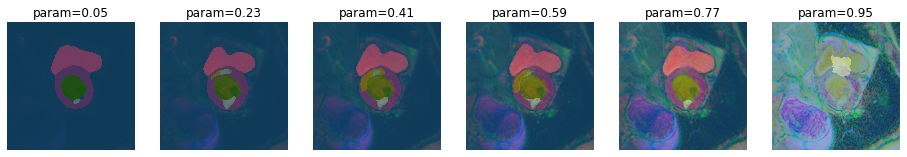

In [98]:
plot_series(get_brightness_series(img(),model, end = 0.99, step = 0.18), nrow=1)

In [33]:
results = eval_bright_series(img(),trueMask(),model, end = 0.99, components=["bg","LV","MY","RV","edema","scar"])

In [34]:
(alt
 .Chart(results.melt(id_vars=['brightness'],value_vars=['LV','MY','RV','edema','scar']))
 .mark_line()
 .encode(
     x="brightness",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

### Sensitivity to contrast

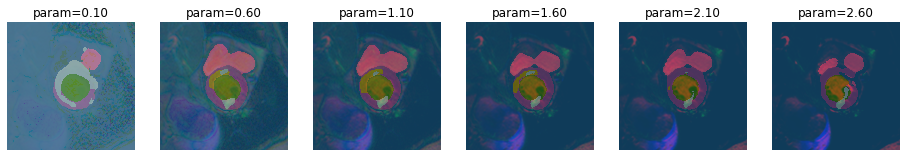

In [99]:
plot_series(get_contrast_series(img(),model, start=0.1, end=3, step=0.5), nrow = 1)

In [36]:
results = eval_contrast_series(img(),trueMask(),model, end = 2.5, step = 0.3, components=["bg","LV","MY","RV","edema","scar"])

In [37]:
(alt
 .Chart(results.melt(id_vars=['contrast'],value_vars=['LV','MY','RV','edema','scar']))
 .mark_line()
 .encode(
     x="contrast",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

### Sensitivity to zoom

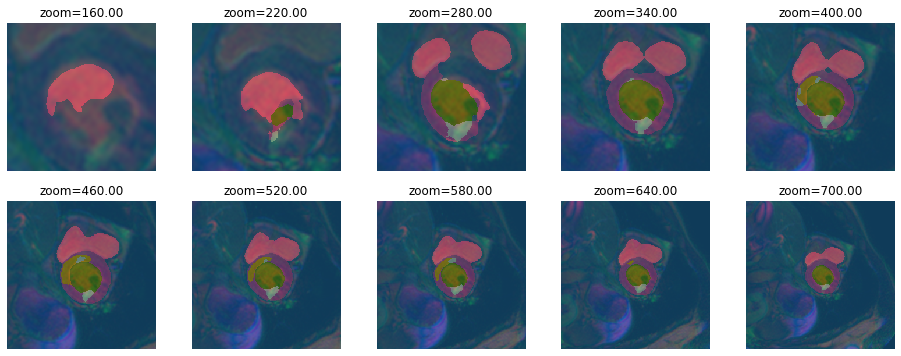

In [88]:
plot_series(get_zoom_series(img(),model,start=160,end=750,step=60, finalSize=480), param_name="zoom", nrow=2, vmax=5)

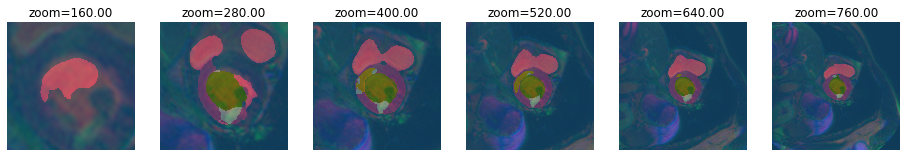

In [100]:
plot_series(get_zoom_series(img(),model,start=160,end=770,step=120, finalSize=480), param_name="zoom", nrow=1, vmax=5)

In [89]:
results = eval_zoom_series(img(),trueMask(),model,start=160,end=900,step=20,finalSize=480,components=["bg","LV","MY","RV","edema","scar"])

In [90]:
(alt
 .Chart(results.melt(id_vars=['scale'],value_vars=['LV','MY','RV','edema','scar']))
 .mark_line()
 .encode(
     x="scale",
     y="value",
     color="variable",
     tooltip="value"
 )
 .properties(width=700,height=300)
 .interactive()
)

alt.Chart(...)

In [41]:
gif_series(
    get_zoom_series(img(),model, start=50, end=900,step=50),
    "example/myops/zoom.gif",
    param_name="scale",
    duration=400,
    vmax=5
)

![segmentation sensitivity to zoom](example/myops/zoom.gif)

**IDEA: Channel imbalance transformation** 
For multi-channel images it might be useful to consider transformations that work differently on different channels.

## Robustness to MR artifacts

**It would be nice to analyze the effect of MR artifacts. However, we are dealing with multi-channel images here. Each channel is a separate MR image. So it is not obvious how to deal with this.**